In [1]:
import jax
import jax.numpy as np

from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils
import structure_vb_lib.structure_optimization_lib as s_optim_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl
from bnpmodeling_runjingdev import influence_lib, cluster_quantities_lib, result_loading_utils
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
seed = 98765
onp.random.seed(seed)

# Load data

In [3]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [4]:
print(g_obs.shape)

(155, 7, 2, 21)


In [5]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

In [6]:
onp.unique(labels)

array(['Chawia', 'Mbololo', 'Ngangao', 'Yale'], dtype='<U32')

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

alpha0 = 3.0
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': 3.0, 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 20

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs = n_obs,
                                                      n_loci = n_loci,
                                                      n_allele = n_allele, 
                                                      k_approx = k_approx, 
                                                      prng_key = jax.random.PRNGKey(seed))
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0, ub=inf)


# Initialize

In [11]:
structure_model_lib.get_kl(g_obs, 
                           vb_params_dict, 
                           prior_params_dict, 
                           gh_loc, 
                           gh_weights)

DeviceArray(21146.61530633, dtype=float64)

In [12]:
t0 = time.time() 

vb_params_dict = s_optim_lib.initialize_structure(g_obs, 
                                                  vb_params_dict, 
                                                  vb_params_paragami,
                                                  prior_params_dict, 
                                                  gh_loc, 
                                                  gh_weights, 
                                                  seed = seed)

print('Initialization time: {:.03f}secs'.format(time.time() - t0))

Initialization time: 9.742secs


In [13]:
structure_model_lib.get_kl(g_obs, 
                           vb_params_dict, 
                           prior_params_dict, 
                           gh_loc, 
                           gh_weights)

DeviceArray(19627.88370782, dtype=float64)

# Optimize

In [14]:
vb_opt_dict, vb_opt, ez_opt, out, _ = \
    s_optim_lib.optimize_structure(g_obs,
                                   vb_params_dict,
                                   vb_params_paragami,
                                   prior_params_dict, 
                                   gh_loc, 
                                   gh_weights)

compiling objective and derivatives ... 
done. Compile time: 44.858sec
Running L-BFGS-B ...
L-BFGS-B time: 3.957sec
BFGS out:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Running trust-ncg ... 
Newton time: 2.565sec
Newton out:  Optimization terminated successfully.
done. 


In [15]:
out.fun

array(13533.40950931)

In [16]:
# vb_dict_tmp = paragami.load_folded('../fits/thrush_fits/thrush_fit_alpha3.0.npz')[0]
# np.abs(vb_params_paragami.flatten(vb_dict_tmp, free = True) -vb_opt).max()

# At the optimum, define the sensitivity object

In [17]:
def objective_fun(vb_params_free, epsilon): 
    
    # this actually does not depend on epsilon! 
    # we will set the perturbation later
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return structure_model_lib.get_kl(g_obs, 
                                      vb_params_dict,
                                      prior_params_dict,
                                      gh_loc, 
                                      gh_weights).squeeze()

In [18]:
# Define the linear sensitivity class
vb_sens = HyperparameterSensitivityLinearApproximation(
                    objective_fun = objective_fun, 
                    opt_par_value = vb_opt, 
                    hyper_par_value0 = np.array([0.]),
                    # null for now. will set later
                    hyper_par_objective_fun = lambda x, y: 0.)


Compiling hessian solver ...
Hessian solver compile time: 68.9593sec

Compiling cross hessian...
Cross-hessian compile time: 0.0502756sec

LR sensitivity time: 0.0309765sec



# Check out the fit

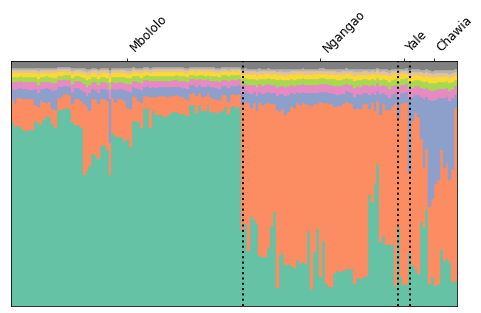

In [20]:
e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

# sort everything within populations
perm_obs = data_utils.cluster_admix_get_indx_within_labels(onp.array(e_ind_admix),
                                                               labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm_labels = onp.argsort(_labels)
perm_obs = perm_obs[perm_labels]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                 ax,
                                 8, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm_labels], ax);

# Define posterior statistic of interest

In [23]:
def get_e_ind_admix_indx(vb_params_free, n_indx = None): 
    # returns the individual admixtures for a set of individuals in n_indx
    
    # get dictionary
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    if n_indx is None: 
        n_indx = np.arange(vb_params_dict['ind_admix_params']['stick_means'].shape[0])
    
    # get sticks from these individual 
    stick_means = vb_params_dict['ind_admix_params']['stick_means'][n_indx]
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos'][n_indx]
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        stick_means, 
                        stick_infos,
                        gh_loc,
                        gh_weights)
    
    return e_ind_admix

In [33]:
mbololo_outlier_indx = onp.argwhere((e_ind_admix[:, 2] > 0.1) & (labels == 'Mbololo')).squeeze()
def g_mbololo(vb_params_free): 
    
    # get this individual's admixutre
    admix = get_e_ind_admix_indx(vb_params_free, n_indx = mbololo_outlier_indx)
    
    # posterior statistic of interest: 
    # proportion of "purple" 
    return admix[2] 


chawia_indx = onp.argwhere(labels == 'Chawia').squeeze()
def g_chawia(vb_params_free): 
    
    # get this individual's admixutre
    admix = get_e_ind_admix_indx(vb_params_free, n_indx = chawia_indx)
    
    # posterior statistic of interest: 
    # proportion of "purple" 
    return admix.mean(0)[2]


ngangao_outlier_indx = onp.argwhere((e_ind_admix[:, 0] > 0.4) & (labels == 'Ngangao')).squeeze()
def g_ngangao(vb_params_free): 
    
    # get this individual's admixutre
    admix = get_e_ind_admix_indx(vb_params_free, n_indx = ngangao_outlier_indx)
    
    # posterior statistic of interest: 
    # proportion of "green" 
    return admix.mean(0)[0]



In [158]:
post_stat = 'chawia'

if post_stat == 'mbololol': 
    g = g_mbololo
    outlier_indx = mbololo_outlier_indx
elif post_stat == 'chawia': 
    g = g_chawia
    outlier_indx = chawia_indx
elif post_stat == 'ngangao': 
    g = g_ngangao
    outlier_indx = ngangao_outlier_indx
else: 
    raise NotImplementedError()

In [159]:
g(vb_opt)

DeviceArray(0.24608376, dtype=float64)

# Get influence function

In [160]:
# parameter for the worst-case: 
# negative because we want worst-case downward perturbation
delta = -1.0

In [161]:
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           vb_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'ind_admix_params')

In [162]:
def get_influence(g): 
    print('computing gradient ...')
    t0 = time.time()
    get_grad_g = jax.jacobian(g)
    grad_g = get_grad_g(vb_opt).block_until_ready()
    grad_g_time = time.time() - t0  
    print('Elapsed: {:.03f}sec'.format(grad_g_time))
        
    # get influence function
    print('inverting Hessian (twice) ...')
    t0 = time.time()
    
    influence_grid, grad_g_hess_inv = influence_operator.get_influence(logit_v_grid, 
                                                                       grad_g)
    
    influence_grid_x_prior, _ = influence_operator.get_influence(logit_v_grid, 
                                                                 grad_g, 
                                                                 normalize_by_prior = False)
    
    hess_inv_time = time.time() - t0
    print('Elapsed: {:.03f}sec'.format(hess_inv_time))
    
    
    # get worst case object
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                     logit_v_grid = logit_v_grid, 
                                                     delta = delta,
                                                     cached_influence_grid = influence_grid)
          
    return influence_grid, influence_grid_x_prior, grad_g_hess_inv, worst_case

In [163]:
logit_v_grid = np.linspace(-6, 6, 100)
influence_grid, influence_grid_x_prior, grad_g_hess_inv, worst_case = get_influence(g)

computing gradient ...
Elapsed: 0.070sec
inverting Hessian (twice) ...
Elapsed: 2.469sec


In [164]:
# set up prior perturbation class for plotting
prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = worst_case.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.378422e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.552745e-01
  warnings.warn(


In [165]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, worst_case, ax): 
    
    # plot y = 0 line
    for i in range(3): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot influence x prior
    ax[1].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
    
    # plot l-inf worst-case perturbation
    wc_log_phi = worst_case.log_phi(logit_v_grid)
    ax[2].plot(logit_v_grid, wc_log_phi, color = 'grey')
    ax[2].fill_between(logit_v_grid, 0, wc_log_phi, color = 'grey', alpha = 0.5)
    
    for cp in worst_case.change_points: 
        ax[1].axvline(cp, color = 'grey', linestyle = 'dashed')
    
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('influence x prior')
    ax[2].set_ylabel('worst-case log phi')


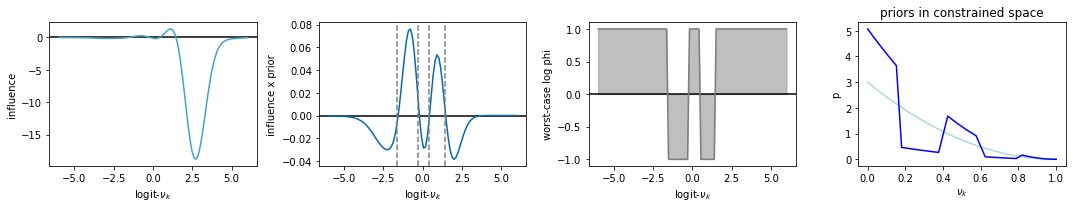

In [166]:
fig, axarr = plt.subplots(1, 4, figsize = (15, 3),  sharex = False) 

plot_influence_grid(influence_grid,
                    influence_grid_x_prior,
                    worst_case,
                    axarr)

for j in range(3): 
    axarr[j].set_xlabel(r'logit-$\nu_k$')
    
    
# plot perturbed prior 
prior_perturbation._plot_priors_constrained(axarr[-1])

fig.tight_layout()


# Fit for a range of epsilon

In [167]:
def get_loss(vb_params_free, epsilon): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    # get perturbation 
    e_log_phi = lambda means, infos : worst_case.get_e_log_linf_perturbation(means, infos) * epsilon
    
    # now add the dependence on epsilon
    return structure_model_lib.get_kl(g_obs, 
                                      vb_params_dict,
                                      prior_params_dict,
                                      gh_loc, 
                                      gh_weights, 
                                      e_log_phi = e_log_phi).squeeze()

In [168]:
get_fun = jax.jit(get_loss)

get_grad = jax.jit(jax.grad(get_loss, argnums = 0))

def _get_hvp(x, hyper_param0, v):
    return jax.jvp(jax.grad(get_loss, argnums = 0), (x, hyper_param0), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

In [169]:
def refit_with_epsilon(epsilon, new_init_dict):
    
    vb_opt_pert = optimize_kl(lambda x : get_fun(x, epsilon),
                             new_init_dict, 
                             vb_params_paragami, 
                             get_grad = lambda x : get_grad(x, epsilon),
                             get_hvp = lambda x, v: get_hvp(x, epsilon, v),
                             run_lbfgs = False,
                             run_newton = True)[1]                             

    return vb_opt_pert

In [170]:
epsilon_vec = np.linspace(0, 1., 11)
print(epsilon_vec)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [171]:
refit_list = []

new_init_dict = deepcopy(vb_opt_dict)

for epsilon in epsilon_vec: 
    print('\n################')
    print('re-optimzing with epsilon = ', epsilon)
    print('################')
    
    refit_free = refit_with_epsilon(epsilon, new_init_dict)
    refit_list.append(refit_free)
    
    new_init_dict = deepcopy(vb_params_paragami.fold(refit_free, free = True))


################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 43.757sec
Running trust-ncg ... 
Newton time: 0.035sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.1
################
compiling objective and derivatives ... 
done. Compile time: 3.084sec
Running trust-ncg ... 
Newton time: 6.294sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.2
################
compiling objective and derivatives ... 
done. Compile time: 3.082sec
Running trust-ncg ... 
Newton time: 7.171sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.3
################
compiling objective and derivatives ... 
done. Compile time: 3.091sec
Running trust-ncg ... 
Newton time: 6.364sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with

# Get linear response predictions

In [172]:
# set LR sensitivity class
f_obj = func_sens_lib.FunctionalPerturbationObjective(worst_case.log_phi, 
                                                          vb_params_paragami, 
                                                          e_log_phi = lambda x,y : worst_case.get_e_log_linf_perturbation(x,y), 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'ind_admix_params')

vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)

Compiling cross hessian...
Cross-hessian compile time: 0.36526sec

LR sensitivity time: 0.378703sec



In [173]:
lr_list = []

for epsilon in epsilon_vec: 
        
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(epsilon))

# Check free parameters

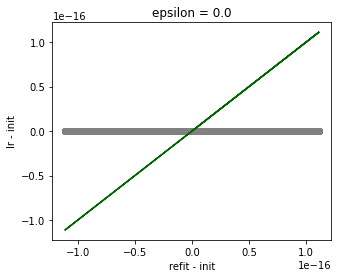

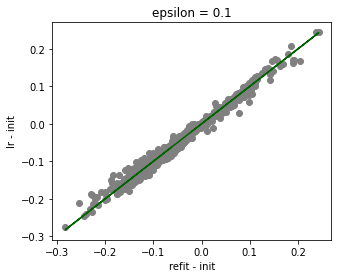

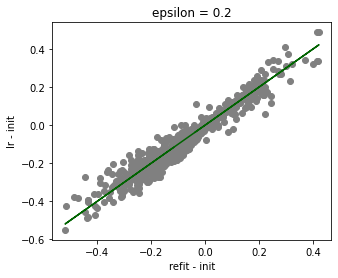

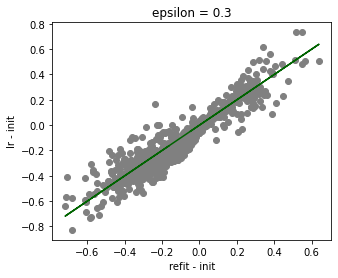

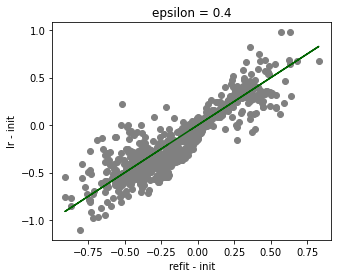

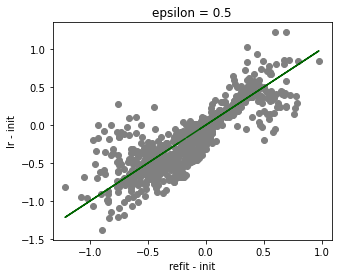

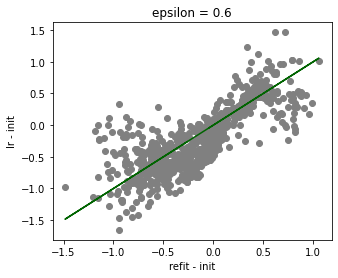

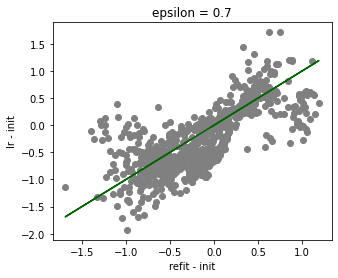

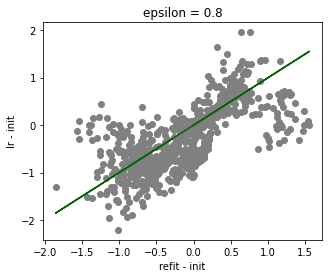

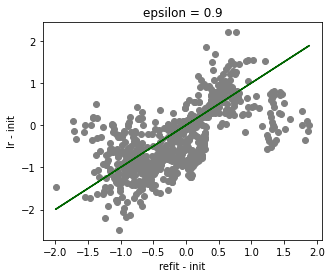

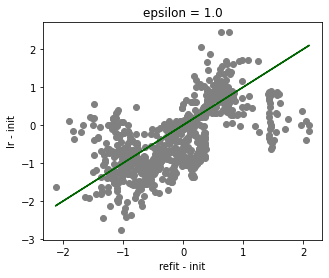

In [174]:
for i in range(len(epsilon_vec)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                                         lr_list[i],
                                         vb_opt,
                                         ax, 
                                         alpha = 1.)
    
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    

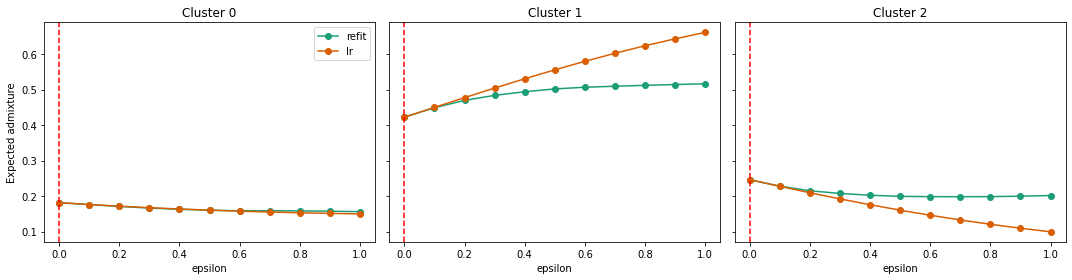

In [200]:
fig, axarr = plt.subplots(1, 3, figsize = (15, 4), sharey = True)

def _weights_fun(x, k): 
    admix = get_e_ind_admix_indx(x, n_indx = outlier_indx)
    
    # make sure it is 2d
    admix = admix.reshape(-1, k_approx)
    
    return admix.mean(0)[k]

# in sample number of clusters
for i in range(3): 
    axarr[i].set_title('Cluster {}'.format(i))
    
    result_loading_utils.plot_post_stat_per_epsilon(lambda x : _weights_fun(x, i),
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[i])
    
    axarr[i].axvline(0, linestyle = '--', color = 'red')
    
axarr[0].set_ylabel('Expected admixture')
axarr[0].legend()
fig.tight_layout();

In [183]:
admix0 = get_e_ind_admix_indx(refit_list[0], n_indx = outlier_indx)
admix_refit = get_e_ind_admix_indx(refit_list[-1], n_indx = outlier_indx)
admix_lr = get_e_ind_admix_indx(lr_list[-1], n_indx = outlier_indx)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


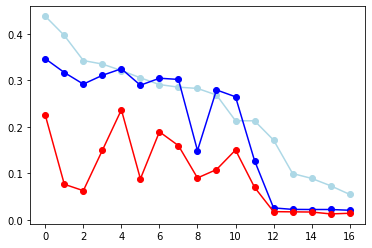

In [199]:
k = 2

tmp = admix0[:, k]
tmp_perm = onp.argsort(-tmp)
plt.plot(tmp[tmp_perm], '-o', color = 'lightblue')
plt.plot(admix_refit[tmp_perm, k], '-o', color = 'blue')
plt.plot(admix_lr[tmp_perm, k], '-o', color = 'red')

In [176]:
# c_indx = onp.argwhere(labels == 'Chawia').squeeze()

# plt.plot(get_e_ind_admix_indx(refit_list[0], n_indx = c_indx).mean(0), '-o', color = 'lightblue')
# plt.plot(get_e_ind_admix_indx(refit_list[-1], n_indx = c_indx).mean(0), '-o', color = 'blue')
# plt.plot(get_e_ind_admix_indx(lr_list[-1], n_indx = c_indx).mean(0), '-o', color = 'red')

In [177]:
# plt.plot(get_e_ind_admix_indx(refit_list[0], n_indx = 24), '-o', color = 'lightblue')
# plt.plot(get_e_ind_admix_indx(refit_list[-1], n_indx = 24), '-o', color = 'blue')
# plt.plot(get_e_ind_admix_indx(lr_list[-1], n_indx = 24), '-o', color = 'red')

In [178]:
# fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# # in sample number of clusters
# result_loading_utils.plot_post_stat_per_epsilon(foo_fun, 
#                                                refit_list,
#                                                lr_list,
#                                                epsilon_vec, 
#                                                axarr[0])

# axarr[0].legend()

In [179]:
def get_inferred_admixture_and_plot(vb_free_params, ax): 
    # get inferred admixture
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_params_paragami.fold(vb_free_params, free = True), 
                                                               gh_loc,
                                                               gh_weights)[0]
    
    # plot admixtures
    plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                     ax,
                                     8, 
                                     cmap_colors = plt.get_cmap('Set2').colors);

    # print labels 
    plotting_utils.draw_region_separation(labels[perm_labels], ax);

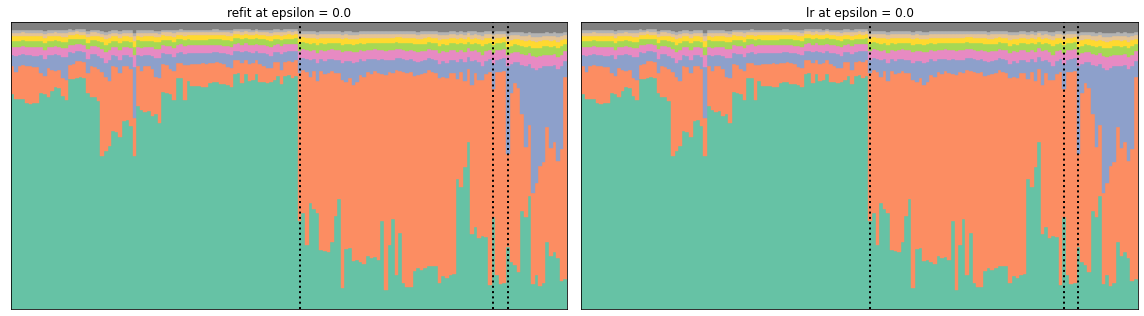

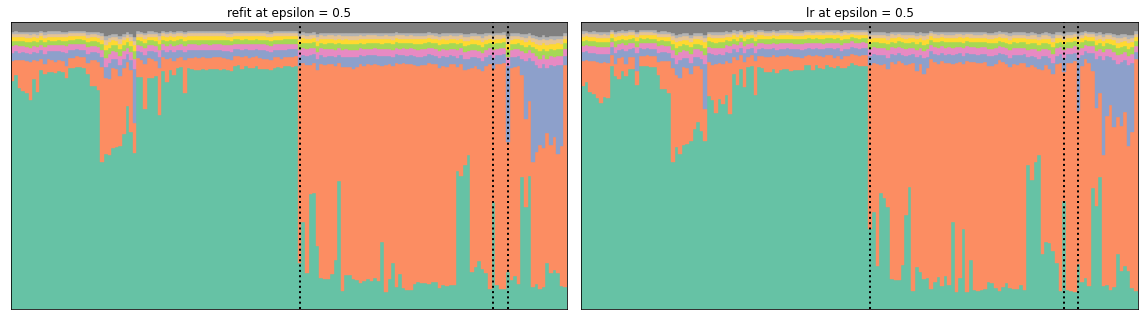

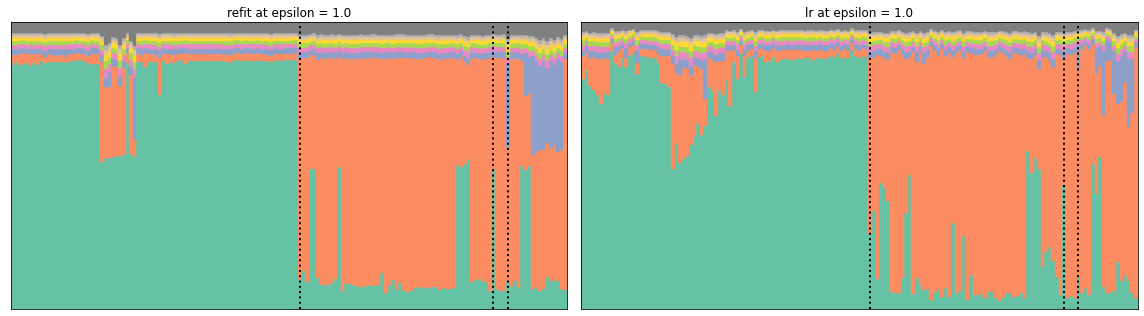

In [180]:
which_epsilons = [0, 5, -1]

for i in which_epsilons: 

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    
    ax[0].set_title('refit at epsilon = {}'.format(epsilon_vec[i]))
    ax[1].set_title('lr at epsilon = {}'.format(epsilon_vec[i]))
    
    # refit
    get_inferred_admixture_and_plot(refit_list[i], ax[0])
    
    # lr 
    get_inferred_admixture_and_plot(lr_list[i], ax[1])
    
    # just remove these labels for now
    for j in range(2): 
        ax[j].set_xticks([]) 

    fig.tight_layout()
    